In [5]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import deepthought, mne, os

from deepthought.util.logging_util import configure_custom
configure_custom(debug=False)
mne.set_log_level('INFO')

### TODO: change this for each subject
subject = 'P01'

from deepthought.datasets.openmiir.metadata import get_stimuli_version
STIMULI_VERSION = get_stimuli_version(subject)

## NOTE: ERPs seem to be slightly nicer when we do NOT resample but work on 512 Hz data
sfreq = 64

In [3]:
from deepthought.experiments.bcmi2015.preprocessing import load_and_preprocess_raw
raw, trial_events, beat_events = load_and_preprocess_raw(subject, sfreq=sfreq, verbose=False)

Loading raw data for subject "P01" from /imaging/deepthought/datasets/OpenMIIR/eeg/mne/P01-raw.fif
540 events found
Events id: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42   43
   44  111  112  113  114  121  122  123  124  131  132  133  134  141  142
  143  144  211  212  213  214  221  222  223  224  231  232  233  234  241
  242  243  244 1000 1111 2001]
This file contains some EEG channels marked as bad: [u'P8', u'P10', u'T8']
Interpolating bad channels...
Channel interpolation is currently only implemented for EEG. The MEG channels marked as bad will remain untouched.
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 289
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors
Band-pass filtering from 0.5 - 30 Hz


[Parallel(n_jobs=4)]: Done   1 out of  61 | elapsed:    0.7s remaining:   39.2s
[Parallel(n_jobs=4)]: Done  11 out of  61 | elapsed:    2.1s remaining:    9.7s
[Parallel(n_jobs=4)]: Done  24 out of  61 | elapsed:    4.0s remaining:    6.2s
[Parallel(n_jobs=4)]: Done  37 out of  61 | elapsed:    5.9s remaining:    3.8s
[Parallel(n_jobs=4)]: Done  50 out of  61 | elapsed:    7.7s remaining:    1.7s
[Parallel(n_jobs=4)]: Done  61 out of  61 | elapsed:    9.2s finished


360 events found
Events id: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42   43
   44  111  112  113  114  121  122  123  124  131  132  133  134  141  142
  143  144  211  212  213  214  221  222  223  224  231  232  233  234  241
  242  243  244 1111 2001]
trial events: (360, 3)
Loading stimulus metadata from /imaging/deepthought/datasets/OpenMIIR/meta/Stimuli_Meta.v1.xlsx
beat events: (7340, 3)
360 events found
Events id: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42   43
   44  111  112  113  114  121  122  123  124  131  132  133  134  141  142
  143  144  211  212  213  214  221  222  223  224  231  232  233  234  241
  242  243  244 1111 2001]
Reading /imaging/deepthought/datasets/OpenMIIR/eeg/preprocessing/ica/P01-100p_64c-ica.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
Now restoring ICA solution ...
Ready.
<ICA  |  epochs decomposition, fit (fastica): 529100 samp

In [6]:
from deepthought.datasets.openmiir.preprocessing.events import filter_beat_events, remove_overlapping_events
from deepthought.analysis.tempo.autocorrelation import *
from deepthought.datasets.openmiir.metadata import load_stimuli_metadata
meta = load_stimuli_metadata(version=STIMULI_VERSION)

Loading stimulus metadata from /imaging/deepthought/datasets/OpenMIIR/meta/Stimuli_Meta.v1.xlsx


In [9]:
import matplotlib.gridspec as gridspec

def plot_bar_evoked_paper(raw, beat_events,       # data to plot and beat markers
                          stim_id,                # selected stimulus id
                          tmin=-0.1, tmax=2.4,    # time window in s
                          allow_overlap=False,    # allow overlapping epochs?
                          override_step_bpm=None  # for manipulating the assumed BPM (i.e. simulating wrong assumptions)
                         ):
    
    tick_fontsize = 13
    
    sfreq = raw.info['sfreq']
    
    gt_beat_tempo = float(meta[stim_id]['bpm'])
    gt_bar_tempo = float(gt_beat_tempo) / meta[stim_id]['beats_per_bar']
    
#     print stim_id, meta[stim_id]['label'], meta[stim_id]['approx_bar_length']
    
    fig = plt.figure(figsize=(15,5))
    subplot_grid = gridspec.GridSpec(2, 3, height_ratios=[1.4,1])

    bar_length = gt_bar_tempo / 60.0 #meta[stim_id]['approx_bar_length']
    bar_markers = []
    for b in xrange(16):
        if b*bar_length < tmax:
            bar_markers.append(b*bar_length * 1000)
        
    def get_erp(cond):
        bar_events = filter_beat_events(beat_events, stimulus_ids=[stim_id], beat_counts=[1], conditions=[cond])
        if override_step_bpm is not None:
            # simulate wrong bar length corresponding to override_step_bpm
            sample_len = bpm_to_autocorr_index(override_step_bpm, sfreq=sfreq)
            first_onset = bar_events[0,0]
            for i, event in enumerate(bar_events):
                event[0] = first_onset + i * sample_len
            
        if not allow_overlap:
            bar_events = remove_overlapping_events(bar_events, tmin, tmax, sfreq)
#         print 'selected events: ', len(bar_events)
        
        eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False)
        bar_epochs = mne.Epochs(raw, bar_events, None,
                                  tmin, tmax, preload=True,
                                  proj=False, picks=eeg_picks, verbose=False)
        evoked = bar_epochs.average()
#         print evoked.data.shape
        evoked.resample(sfreq)
#         print evoked.data.shape
        return evoked

    erps = dict()
    for cond in [1,2,3]:
        erps[cond] = get_erp(cond)
    
    def plot_erp(axes, evoked):
#         evoked.plot(axes=axes, show=False, ylim=ylim, hline=[0], titles=perc_titles)
#         [l.set_color('gray') for l in axes.get_lines()]
        times = 1e3 * evoked.times  # time in miliseconds
        uV_scaling = 1e6
        
        erp_mean = evoked.data.mean(axis=0)
        erp_std = evoked.data.std(axis=0)
        hyp_limits = (erp_mean - erp_std, erp_mean + erp_std)                       # std
#         hyp_limits = (np.min(evoked.data, axis=0), np.max(evoked.data, axis=0))   # range
        axes.plot(times, uV_scaling * erp_mean, color='black', linewidth=1)

        axes.set_xlim((times[0], times[-1]))
        axes.set_ylim((-5,5))
        axes.grid()
        
        plt.xlabel('time (ms) relative to downbeat')
        
        for m in bar_markers:
            axes.axvline(m, color='gray', linestyle='--', linewidth=2)
        
        hyp_limits = uV_scaling * np.asarray(hyp_limits)
        axes.fill_between(times, hyp_limits[0], y2=hyp_limits[1], color='black', alpha=0.25)
        
    def plot_tempo_curve(data, stim_id, gt_beat_tempo, gt_bar_tempo, axes=None):
        ac = compute_autocorrelation(data)

        # limit tempo range
        bpm_min = int(np.ceil(autocorr_index_to_bpm(len(ac), sfreq=sfreq)))
        bpm_max = int(np.floor(autocorr_index_to_bpm(1, sfreq=sfreq)))
    #     print bpm_min, bpm_max
    #     bpm_max = min(bpm_max, 220)    
        x = np.arange(bpm_min, 121, 1) 
    
        tempo_curve = compute_tempo_histogram_from_ac(ac, sfreq=sfreq)
        y = tempo_curve(x)

        if axes is None:
            plt.figure(figsize=(10,3))
            axes = plt.gca()
        
        axes.set_xlim((0, x[-1]))
        axes.set_xlabel('tempo (BPM)')
        axes.set_ylabel('autocorrelation')

        axes.plot(x,y, color='black')
    
        axes.axvline(0.5 * gt_bar_tempo, color='grey', linestyle='--', linewidth=2) # half
        axes.axvline(gt_bar_tempo, color='grey', linestyle='--', linewidth=2)
        axes.axvline(2 * gt_bar_tempo, color='grey', linestyle='--', linewidth=2) # double

        axes.grid()  
    
    title_fontsize = 16
    axes = plt.subplot(subplot_grid[0, 0])
    plot_erp(axes, erps[1])
    axes.set_ylabel('data (uV)')
    plt.title('perception', fontsize=title_fontsize)
    
    axes = plt.subplot(subplot_grid[0, 1])
    plot_erp(axes, erps[2])
    plt.setp(axes.get_yticklabels(), visible=False)
    plt.title('cued imagination', fontsize=title_fontsize)

    axes = plt.subplot(subplot_grid[0, 2])
    plot_erp(axes, erps[3])
    plt.setp(axes.get_yticklabels(), visible=False)
    plt.title('uncued imagination', fontsize=title_fontsize)

    axes = plt.subplot(subplot_grid[1, 0])
    plot_tempo_curve(erps[1].data.mean(axis=0), stim_id, gt_beat_tempo, gt_bar_tempo, axes=axes)
    axes.set_ylim((-0.5,0.5))

    axes = plt.subplot(subplot_grid[1, 1])
    plot_tempo_curve(erps[2].data.mean(axis=0), stim_id, gt_beat_tempo, gt_bar_tempo, axes=axes)
    axes.set_ylim((-0.5,0.5))
    axes.set_ylabel('')
    plt.setp(axes.get_yticklabels(), visible=False)
    
    axes = plt.subplot(subplot_grid[1, 2])
    plot_tempo_curve(erps[3].data.mean(axis=0), stim_id, gt_beat_tempo, gt_bar_tempo, axes=axes)
    axes.set_ylim((-0.5,0.5))
    axes.set_ylabel('')
    plt.setp(axes.get_yticklabels(), visible=False)
    
    plt.subplots_adjust(wspace=0.08, hspace=0.3)
#     plt.subplots_adjust(top=0.92)
#     fig.suptitle('#{} {}'.format(stim_id, meta[stim_id]['label']), fontsize=20)
    plt.show()
    
    print 'Top: Mean and standard deviation over all 64 EEG channels of the bar-aligned ERPs' 
    if allow_overlap:
        print '(with epoch overlap)'
    else:
        print '(without epoch overlap)'
    print 'for', meta[stim_id]['label'], 'in conditions 1--3.'
    print 'Bottom: Corresponding autocorrelation scores in the relevant tempo range.'
    print 'Dashed lines indicate downbeats (top) and the approximate bar tempo of the stimulus plus its lower tempo octave (bottom).'
    print 'NOTE: downbeat times are based on audio beat detection in stimulus!'
    return fig

============= correct bar alignment ==============
kept 25 of 80 events
kept 26 of 80 events
kept 25 of 80 events


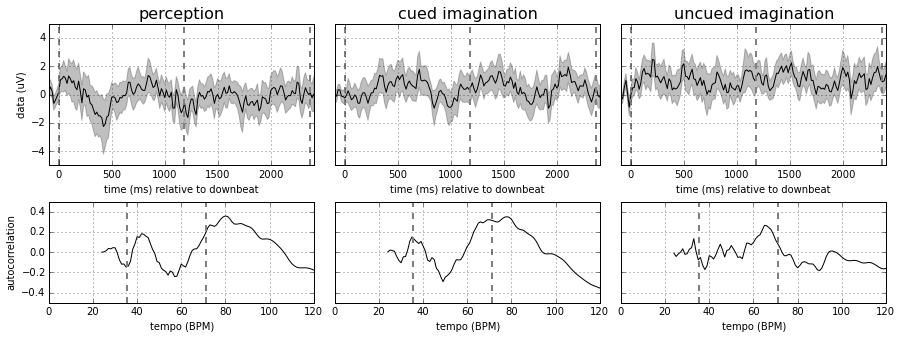

Top: Mean and standard deviation over all 64 EEG channels of the bar-aligned ERPs
(without epoch overlap)
for Chim Chim Cheree (lyrics) in conditions 1--3.
Bottom: Corresponding autocorrelation scores in the relevant tempo range.
Dashed lines indicate downbeats (top) and the approximate bar tempo of the stimulus plus its lower tempo octave (bottom).
NOTE: downbeat times are based on audio beat detection in stimulus!


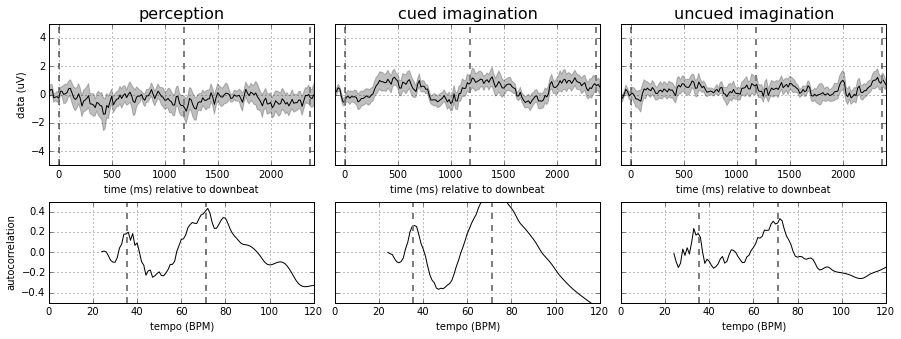

Top: Mean and standard deviation over all 64 EEG channels of the bar-aligned ERPs
(with epoch overlap)
for Chim Chim Cheree (lyrics) in conditions 1--3.
Bottom: Corresponding autocorrelation scores in the relevant tempo range.
Dashed lines indicate downbeats (top) and the approximate bar tempo of the stimulus plus its lower tempo octave (bottom).
NOTE: downbeat times are based on audio beat detection in stimulus!
============= incorrect bar alignment (50 BPM) ==============
kept 27 of 80 events
kept 27 of 80 events
kept 27 of 80 events


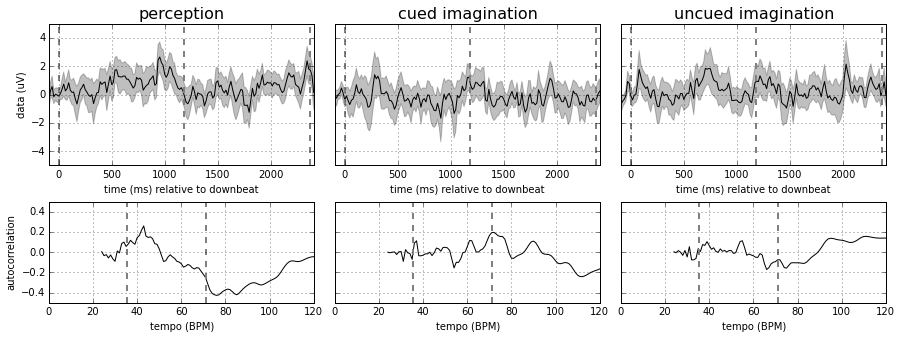

Top: Mean and standard deviation over all 64 EEG channels of the bar-aligned ERPs
(without epoch overlap)
for Chim Chim Cheree (lyrics) in conditions 1--3.
Bottom: Corresponding autocorrelation scores in the relevant tempo range.
Dashed lines indicate downbeats (top) and the approximate bar tempo of the stimulus plus its lower tempo octave (bottom).
NOTE: downbeat times are based on audio beat detection in stimulus!


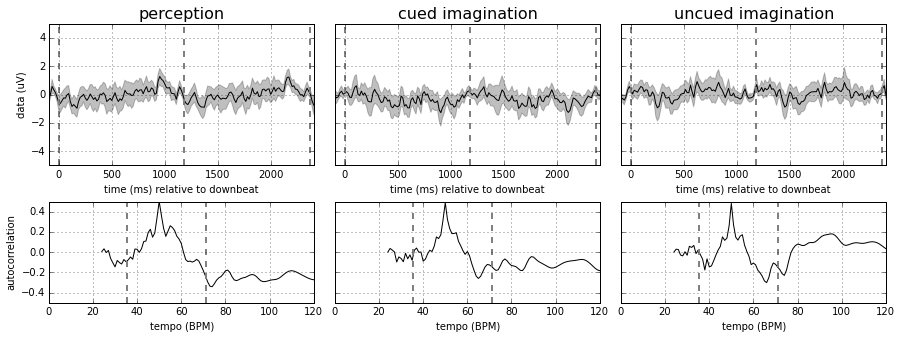

Top: Mean and standard deviation over all 64 EEG channels of the bar-aligned ERPs
(with epoch overlap)
for Chim Chim Cheree (lyrics) in conditions 1--3.
Bottom: Corresponding autocorrelation scores in the relevant tempo range.
Dashed lines indicate downbeats (top) and the approximate bar tempo of the stimulus plus its lower tempo octave (bottom).
NOTE: downbeat times are based on audio beat detection in stimulus!


In [11]:
print '============= correct bar alignment =============='
fig = plot_bar_evoked_paper(raw, beat_events, 1, tmin=-0.1, tmax=2.4, allow_overlap=False, override_step_bpm=None)
# fig.savefig('plots/non-overlap_bar-aligned-ERPs.pdf', bbox_inches='tight')
fig = plot_bar_evoked_paper(raw, beat_events, 1, tmin=-0.1, tmax=2.4, allow_overlap=True, override_step_bpm=None)

wrong_bpm = 50
print '============= incorrect bar alignment ({} BPM) =============='.format(wrong_bpm)
fig = plot_bar_evoked_paper(raw, beat_events, 1, tmin=-0.1, tmax=2.4, allow_overlap=False, override_step_bpm=wrong_bpm)
fig = plot_bar_evoked_paper(raw, beat_events, 1, tmin=-0.1, tmax=2.4, allow_overlap=True, override_step_bpm=wrong_bpm)

In [13]:
# from deepthought.datasets.openmiir.constants import STIMULUS_IDS
# for stim_id in STIMULUS_IDS:
#     fig = plot_bar_evoked_paper(raw, beat_events, stim_id, tmin=-0.1, tmax=2.4, allow_overlap=False)